In [1]:
# libraries
import os
import mne
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import random
import pandas as pd
# import h5py

# import wave
# from scipy.io import wavfile

# import pyprep
# from pyprep.prep_pipeline import PrepPipeline


# # for permutation stats visualization
from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mne.viz import plot_compare_evokeds
from scipy import stats
# from mne.stats import spatio_temporal_cluster_1samp_test


# for save and load dict variables
import pickle

# set working directory
work_dir = '/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/'

# General parameters

In [3]:
####################
#### parameters ####
####################

# subjects to exclude
exclude_ppts = [
    '140', # no data
    '197', # no data
    
    '135', # incomplete data
    '179', # incomplete data
    '182', # incomplete data

    '141', # wrong experiment was run

    '261', # no StimTrak recording

    '115', # unknown

    '187', # too many bad stims
    '200', # too many bad stims
    '259', # too many bad stims

    '268', # not included yet
    '269', # not included yet
    '270', # not included yet
]

#### directory ####
input_dir = work_dir + 'data_preprocessed/5_averaged/'
output_dir = work_dir + 'figures/'

# print(input_dir)
# print(output_dir)

# read in the ERP data:
with open(input_dir + 'all_evokeds.pkl', 'rb') as file:  # Python 3: open(..., 'rb')
    all_evokeds = pickle.load(file)


# get time and channel info from any evoked data
evoked = all_evokeds['100']['ChEn-devi/Eng_001']
time_labels = [str(int(x)) for x in evoked.times*1000]
chan_labels = evoked.info['ch_names']


# create a dictionary for condition key and standard and deviant cells ####
cell_dict = {
    # 'identityMMN_English_in_Chinese': {'deviant': 'ChEn-devi', 'standard': 'EnCh-stan', 'devi_stim': 'English', 'stan_stim': 'English'},
    # 'identityMMN_Chinese_in_English': {'deviant': 'EnCh-devi', 'standard': 'ChEn-stan', 'devi_stim': 'Chinese', 'stan_stim': 'Chinese'},
    # 'identityMMN_English_in_Indian': {'deviant': 'InEn-devi', 'standard': 'EnIn-stan'},
    # 'identityMMN_Indian_in_English': {'deviant': 'EnIn-devi', 'standard': 'InEn-stan'},
    'withinBlockMMN_English_in_Chinese': {'deviant': 'ChEn-devi', 'standard': 'ChEn-stan', 'devi_stim': 'English', 'stan_stim': 'Chinese'},
    'withinBlockMMN_Chinese_in_English': {'deviant': 'EnCh-devi', 'standard': 'EnCh-stan', 'devi_stim': 'Chinese', 'stan_stim': 'English'},
}

# all participants that came this far
all_ppts = all_evokeds.keys()

# English participants
with open('ppts_ENG.txt', 'r') as f:
    ENG_ppts = [line.strip() for line in f]

# Chinese participants
with open('ppts_CHI.txt', 'r') as f:
    CHI_ppts = [line.strip() for line in f]
    
# South Asia participants
with open('ppts_SOME.txt', 'r') as f:
    SOME_ppts = [line.strip() for line in f]

# make a dictionary for participants
ppt_dict = {'ENG': ENG_ppts, 'CHI': CHI_ppts, 'SOME': SOME_ppts}

# Single-participant, single-condition visualization

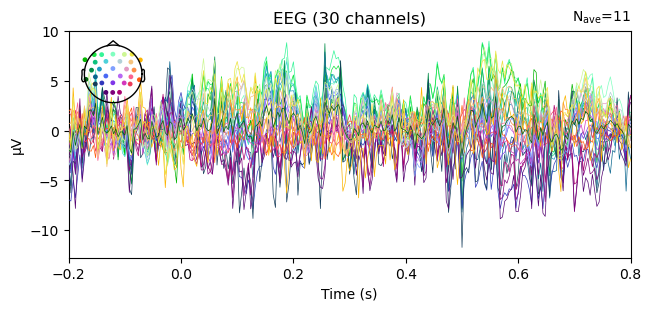

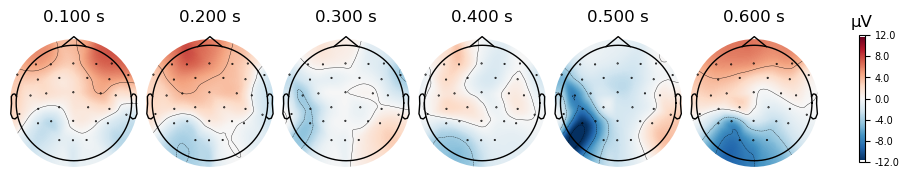

In [57]:
# single-subject, single-condition butterfly
evoked = all_evokeds['100']['ChEn-devi/Eng_001']

# waveform
evoked.plot()

# scalp topography
topo_times = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
evoked.plot_topomap(times=topo_times, colorbar=True)

plt.show()

# Grand-average topographic subplots

## parameters

In [58]:
# choose cell for visualization
# cell = 'identityMMN_English_in_Chinese'
# cell = 'identityMMN_Chinese_in_English'
# cell = 'identityMMN_English_in_Indian'
# cell = 'identityMMN_Indian_in_English'
# cell = 'identityMMN_English_in_Chinese'
cell = 'withinBlockMMN_Chinese_in_English'
# cell = 'withinBlockMMN_English_in_Chinese'


# participant group
# ppt_group = 'ENG'
ppt_group = 'CHI'
# ppt_group = 'SOME'


# get subset participants for the cell
subset_ppts = []
# for each subject
for ppt in ppt_dict[ppt_group]:
    # if it is not in the bad subject list # 
    if (ppt in all_ppts) and (ppt not in exclude_ppts):
        # append that subject to the list
        subset_ppts.append(ppt)

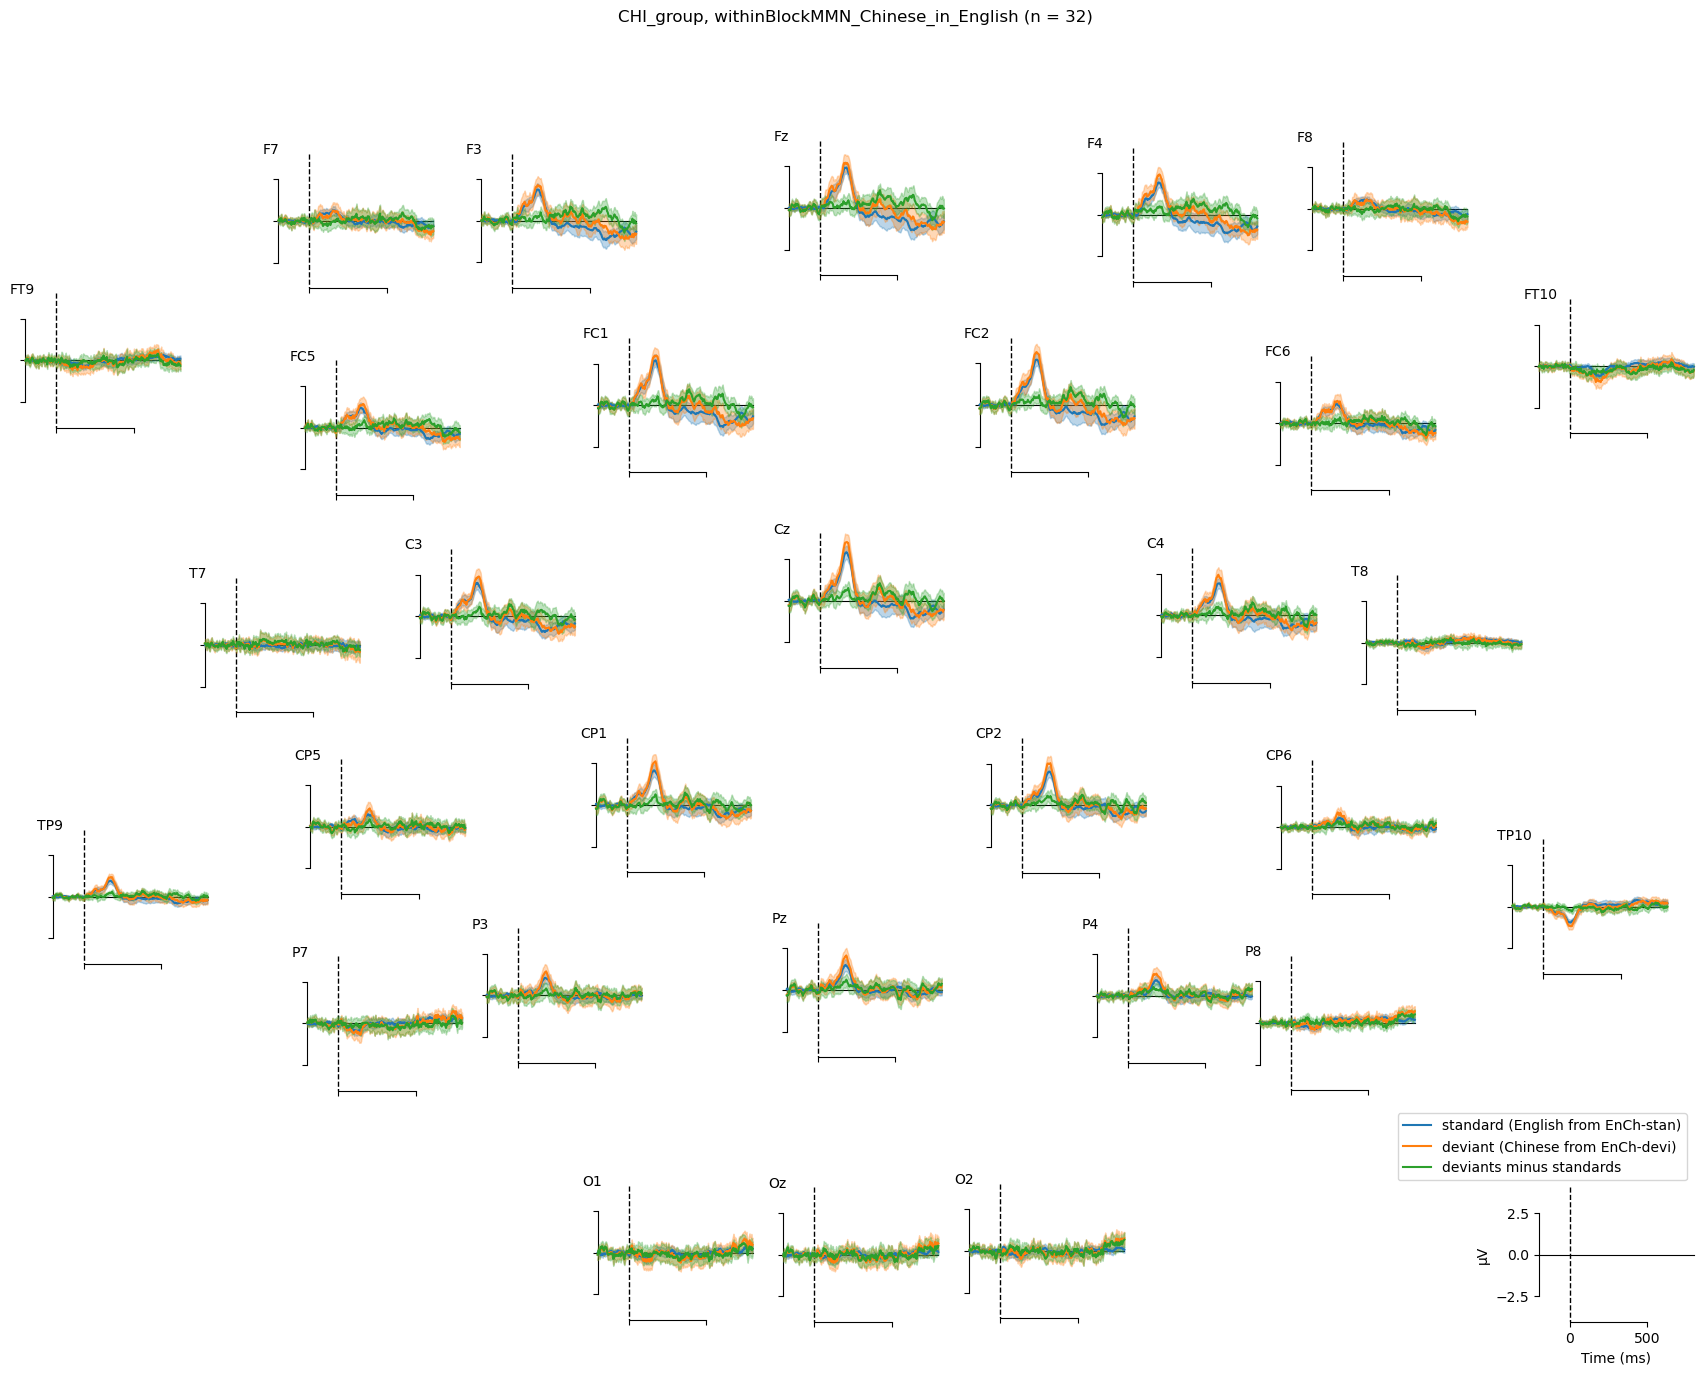

In [60]:
# get legends
legend_stan = 'standard (' + cell_dict[cell]['stan_stim'] + ' from ' + cell_dict[cell]['standard'] + ')'
legend_devi = 'deviant (' + cell_dict[cell]['devi_stim'] + ' from ' + cell_dict[cell]['deviant'] + ')'
legend_diff = 'deviants minus standards'

# # colors
# color_devi = "crimson"
# color_stan = "steelblue"
# color_diff = 'black'


##########################
####  ERP Topographical subplot and ROI waveforms ####
##########################

# extract ERPs
erp_stan = []
erp_devi = []
erp_diff = []
for ppt in subset_ppts:

    # extract conditions
    conditions = all_evokeds[ppt].keys()

    # get standard and deviant keys for pulling out data
    stan_conditions = [ x for x in conditions if x.split('/')[0]==cell_dict[cell]['standard'] ]
    devi_conditions = [ x for x in conditions if x.split('/')[0]==cell_dict[cell]['deviant'] ]

    # compute temporary standard erp
    tmp_stan = mne.combine_evoked([all_evokeds[ppt][x] for x in stan_conditions],
                                  weights='equal')
    # compute temporary deviant erp
    tmp_devi = mne.combine_evoked([all_evokeds[ppt][x] for x in devi_conditions],
                                  weights='equal')
    # compute temporary difference erp
    tmp_diff = mne.combine_evoked([tmp_devi, tmp_stan],
                                  weights=[1,-1]) # 1 for devi, -1 for stan
    # append temporary data to list
    erp_stan.append(tmp_stan)
    erp_devi.append(tmp_devi)
    erp_diff.append(tmp_diff)


# combine data for plotting
evokeds = {}
evokeds[legend_stan] = erp_stan
evokeds[legend_devi] = erp_devi
evokeds[legend_diff] = erp_diff

# # set colors
# colors = {}
# colors[legend_stan] = color_stan
# colors[legend_devi] = color_devi
# colors[legend_diff] = color_diff


################################
#### Topographical subplots ####
################################


# figure title for the waveform
waveform_title = ppt_group + '_group, ' + cell + ' (n = ' + str(len(subset_ppts)) + ')'

##############################
# waveforms across scalp topo
# NOTE: I don't know how to save these plots using the code
fig = mne.viz.plot_compare_evokeds(
    evokeds,
    axes='topo',
    # picks=pick_chans,
    # combine="mean",
    show_sensors=True,
    # colors=colors,
    title = waveform_title,
    # ylim=dict(eeg=[-5, 5]),
    time_unit="ms",
    show=False,
);
##############################

# Grand-average waves and topos

## parameters

In [63]:
# save the plot?
toggle_save_plot = True
# toggle_save_plot = False

# # colors for each condition?
# color_devi = "crimson"
# color_stan = "steelblue"
# color_diff = 'black'

# times to show in topoplots (in seconds)
times = [0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]

# choose a channel(s) for ERP plot
pick_chans = ["Cz", "Fz", "FC1", "FC2", "C3", "C4", "CP1", "CP2"]

# get channel index
ch_inds = np.isin(chan_labels, pick_chans)


# create a dictionary for condition key and standard and deviant cells ####
cell_dict = {
    # 'identityMMN_English_in_Chinese': {'deviant': 'ChEn-devi', 'standard': 'EnCh-stan', 'devi_stim': 'English', 'stan_stim': 'English'},
    # 'identityMMN_Chinese_in_English': {'deviant': 'EnCh-devi', 'standard': 'ChEn-stan', 'devi_stim': 'Chinese', 'stan_stim': 'Chinese'},
    # 'identityMMN_English_in_Indian': {'deviant': 'InEn-devi', 'standard': 'EnIn-stan'},
    # 'identityMMN_Indian_in_English': {'deviant': 'EnIn-devi', 'standard': 'InEn-stan'},
    'withinBlockMMN_English_in_Chinese': {'deviant': 'ChEn-devi', 'standard': 'ChEn-stan', 'devi_stim': 'English', 'stan_stim': 'Chinese'},
    'withinBlockMMN_Chinese_in_English': {'deviant': 'EnCh-devi', 'standard': 'EnCh-stan', 'devi_stim': 'Chinese', 'stan_stim': 'English'},
}

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 3 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


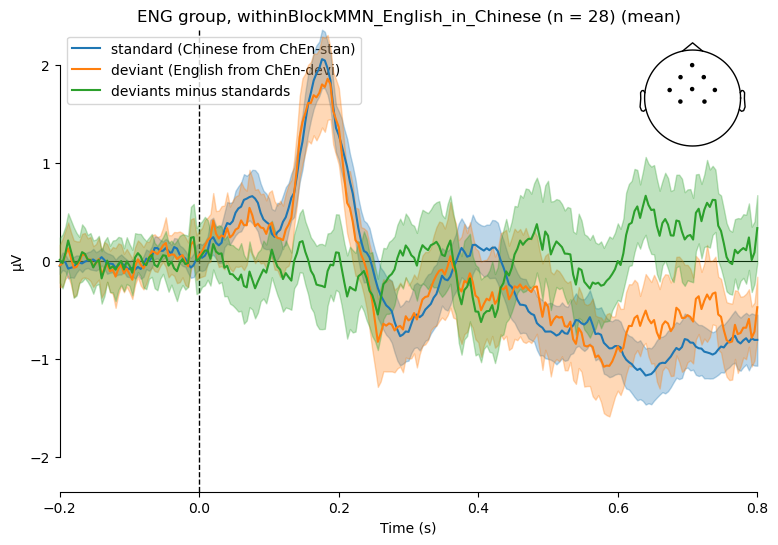

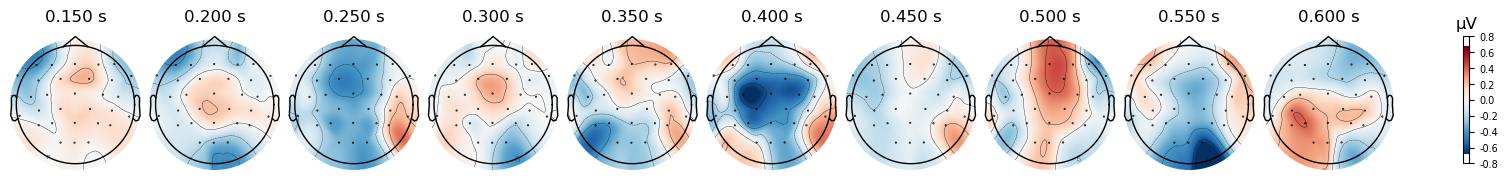

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 27 sensor positions
Interpolating 3 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


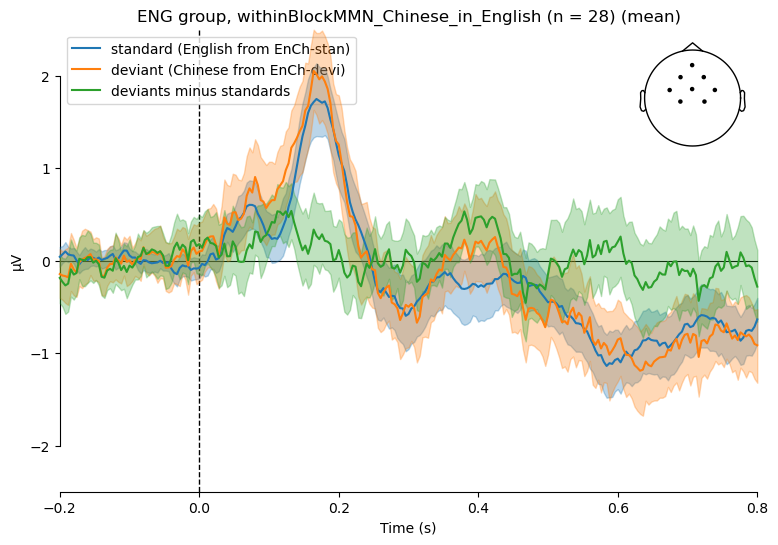

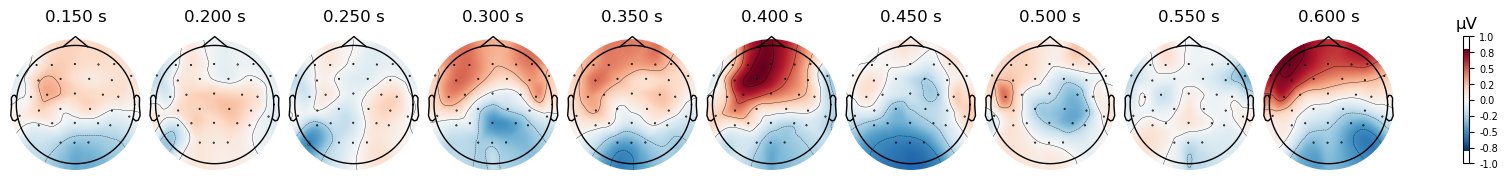

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 4 sensors
Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


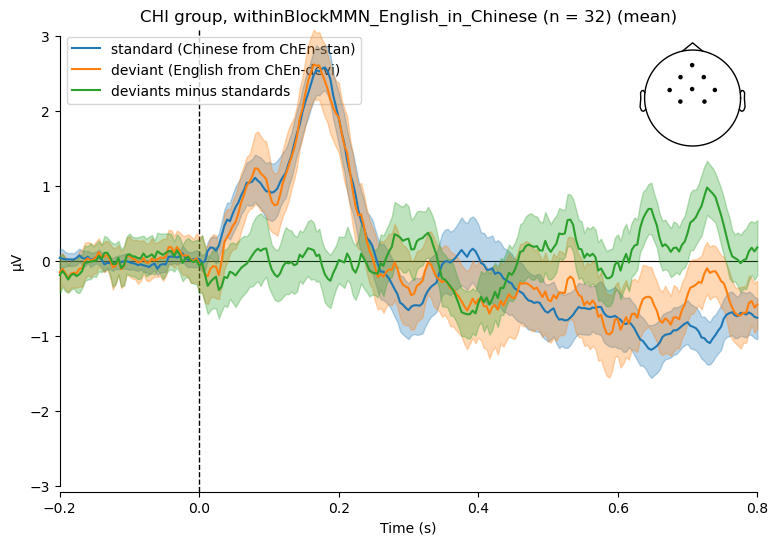

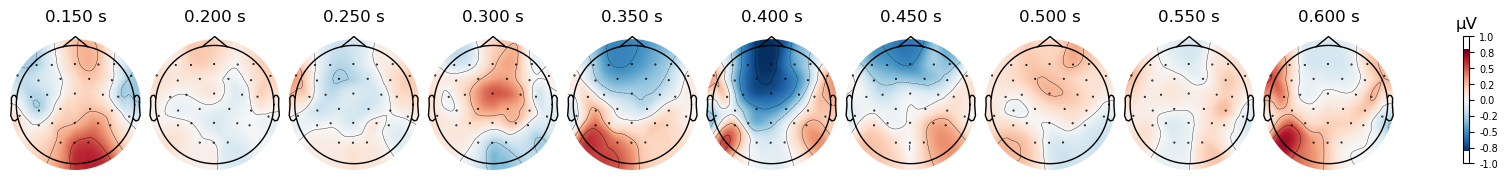

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 26 sensor positions
Interpolating 4 sensors
Identifying common channels ...
combining channels using "mean"
combining channels using "mean"
combining channels using "mean"


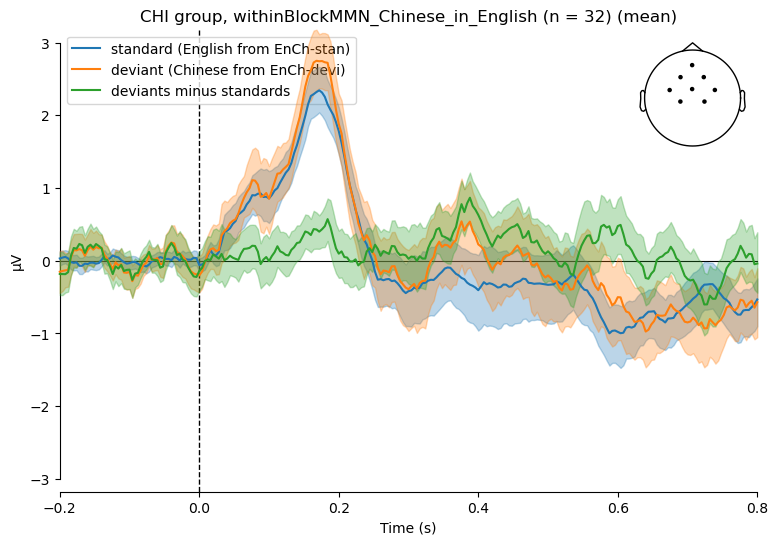

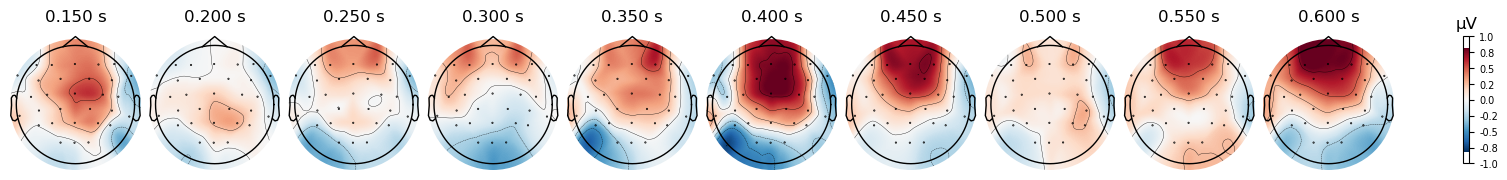

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm


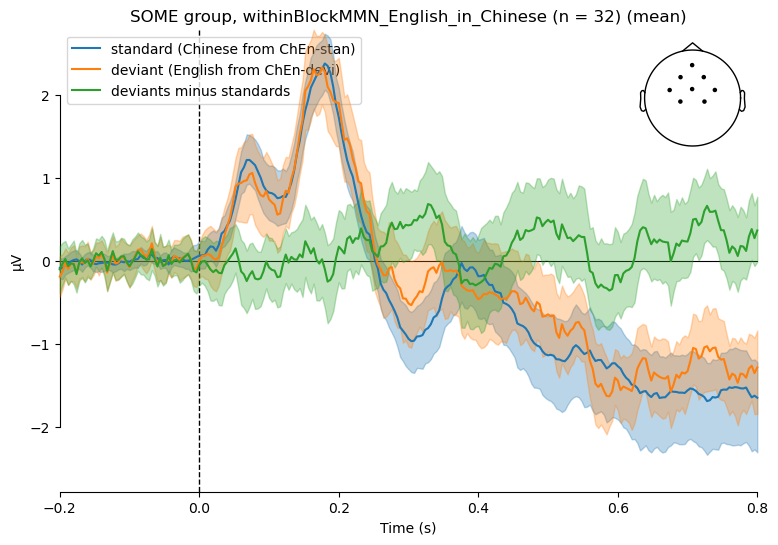

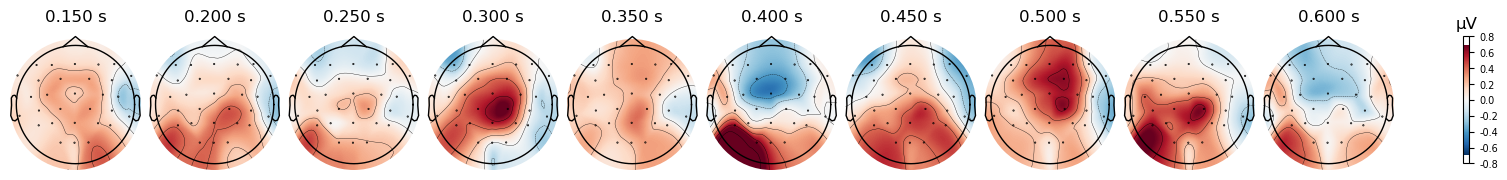

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 28 sensor positions
Interpolating 2 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 94.4 mm


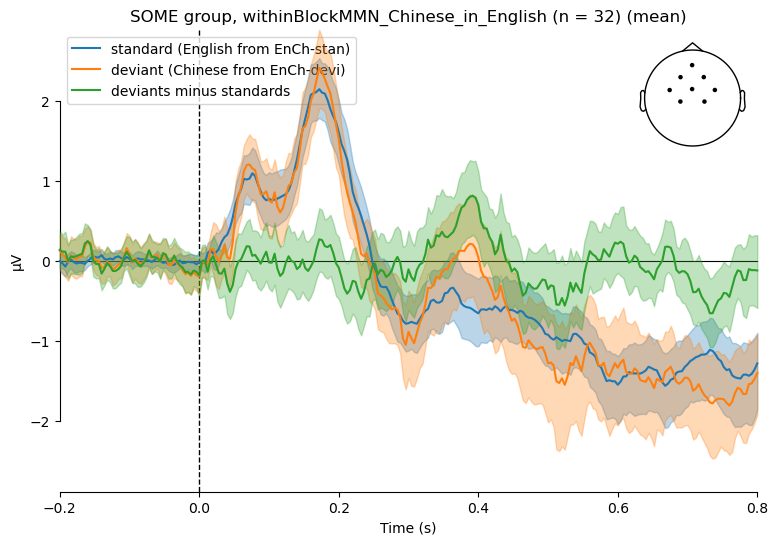

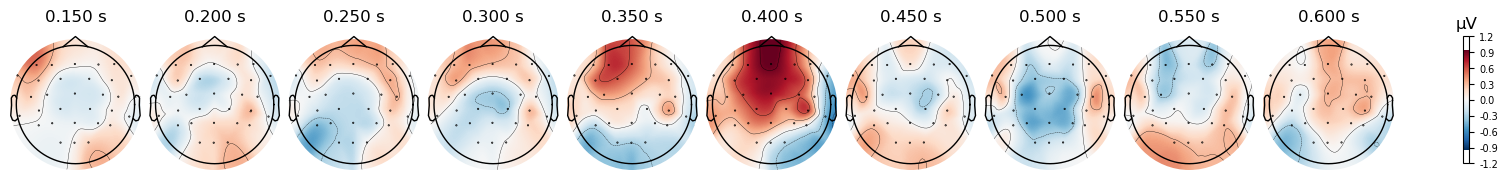

In [64]:
# for each group
for ppt_group in ['ENG', 'CHI', 'SOME']:
    # get participant list
    subset_ppts = []
    for ppt in ppt_dict[ppt_group]:
        # if it is not in the bad subject list # 
        if (ppt not in exclude_ppts) and (ppt in all_ppts):
            # append that subject to the list
            subset_ppts.append(ppt)

    # for each cell
    for cell in cell_dict.keys():
        
        # get legends
        legend_stan = 'standard (' + cell_dict[cell]['stan_stim'] + ' from ' + cell_dict[cell]['standard'] + ')'
        legend_devi = 'deviant (' + cell_dict[cell]['devi_stim'] + ' from ' + cell_dict[cell]['deviant'] + ')'
        legend_diff = 'deviants minus standards'
        
        # extract ERPs
    
        # initialize list
        erp_stan = []
        erp_devi = []
        erp_diff = []
    
        # for each subject
        for ppt in subset_ppts:

            # extract conditions
            conditions = all_evokeds[ppt].keys()
        
            # get standard and deviant keys for pulling out data
            stan_conditions = [ x for x in conditions if x.split('/')[0]==cell_dict[cell]['standard'] ]
            devi_conditions = [ x for x in conditions if x.split('/')[0]==cell_dict[cell]['deviant'] ]
        
            # compute temporary standard erp
            tmp_stan = mne.combine_evoked([all_evokeds[ppt][x] for x in stan_conditions],
                                          weights='equal')
            # compute temporary deviant erp
            tmp_devi = mne.combine_evoked([all_evokeds[ppt][x] for x in devi_conditions],
                                          weights='equal')
            # compute temporary difference erp
            tmp_diff = mne.combine_evoked([tmp_devi, tmp_stan],
                                          weights=[1,-1]) # 1 for devi, -1 for stan
            # append temporary data to list
            erp_stan.append(tmp_stan)
            erp_devi.append(tmp_devi)
            erp_diff.append(tmp_diff)
    
        # compute grand average of difference waves
        grand_avg_diff = mne.grand_average(erp_diff)
        
        
        # combine data for plotting
        evokeds = {}
        evokeds[legend_stan] = erp_stan
        evokeds[legend_devi] = erp_devi
        evokeds[legend_diff] = erp_diff
        
        # # set colors
        # colors = {}
        # colors[legend_stan] = color_stan
        # colors[legend_devi] = color_devi
        # colors[legend_diff] = color_diff
        
        
        # ################################
        # #### plot gav waveform ####
        # ################################
        
        # figure title for the waveform
        waveform_title = ppt_group + ' group, ' + cell + ' (n = ' + str(len(subset_ppts)) + ')'

        wave, ax = plt.subplots(1, 1, figsize=(9, 6))
        
        mne.viz.plot_compare_evokeds(
            evokeds,
            axes=ax,
            picks=pick_chans,
            combine="mean",
            show_sensors=True,
            # colors=colors,
            title = waveform_title,
            # ylim=dict(eeg=[-5, 5]),
            time_unit="s",
            show=False
        )
        # save fig
        if toggle_save_plot:
            wave.savefig(output_dir + '/wave_' + ppt_group + '_' + cell +'.png')
        
        
        #### topomap of difference wave (deviants minus standards) ####
        
        #### plotting topo ####
        topo = grand_avg_diff.plot_topomap(
            ch_type="eeg", 
            times=times, 
            colorbar=True,
            # vlim = (-2,2)
        )
        
        # save fig
        if toggle_save_plot:
            topo.savefig(output_dir + '/topo_' + ppt_group + '_' + cell +'.png')
        
        
        
        # ##################################################################################
        # # For each subject extract the windows average centering the negative peak latency
        # ##################################################################################
        
    
        # # for each subject 
        # for subj in subset_subs:
        #     # compute temporary standard erp
        #     tmp_stan = all_evokeds[subj][key_stan]
        #     # compute temporary deviant erp
        #     tmp_devi = all_evokeds[subj][key_devi]
        #     # compute temporary difference erp
        #     tmp_diff = mne.combine_evoked(
        #         [tmp_devi, tmp_stan],
        #         weights=[1,-1] # 1 for devi, -1 for stan
        #     )
    
            # ##################################
            # #### plot individual waveform ####
    
            # # combine data for plotting
            # evokeds = {}
            # evokeds[legend_stan] = tmp_stan
            # evokeds[legend_devi] = tmp_devi
            # evokeds[legend_diff] = tmp_diff
            
            # # set colors
            # colors = {}
            # colors[legend_stan] = color_stan
            # colors[legend_devi] = color_devi
            # colors[legend_diff] = color_diff
            
            # # figure title for the waveform
            # waveform_title = subj + " " + cell_i
            
            # # figure axes
            # indi_fig, indi_ax = plt.subplots(
            #     1, 1, 
            #     figsize=(7, 5),
            #     layout="constrained"
            # )
            # mne.viz.plot_compare_evokeds(
            #     evokeds,
            #     axes=indi_ax,
            #     picks=pick_chans,
            #     combine="mean",
            #     show_sensors=True,
            #     colors=colors,
            #     title = waveform_title,
            #     # ylim=dict(eeg=[-5, 5]),
            #     time_unit="ms",
            #     show=False,
            # )
            # plt.close()
            
            # # save fig
            # if toggle_save_plot:
            #     indi_fig.savefig(output_dir_individual + '/' + subj + "_" + cell_i +'.png')
            # ##############################

In [77]:
#### combine figures into one ####
mmn_type = 'withinBlockMMN'
wave_files = [
    # 'wave_ENG_identityMMN_Chinese_in_English',
    # 'wave_ENG_identityMMN_English_in_Chinese',
    # 'wave_CHI_identityMMN_Chinese_in_English',
    # 'wave_CHI_identityMMN_English_in_Chinese',     
    # 'wave_SOME_identityMMN_Chinese_in_English', 
    # 'wave_SOME_identityMMN_English_in_Chinese',
    
    'wave_ENG_withinBlockMMN_Chinese_in_English',
    'wave_ENG_withinBlockMMN_English_in_Chinese',
    'wave_CHI_withinBlockMMN_Chinese_in_English',
    'wave_CHI_withinBlockMMN_English_in_Chinese',     
    'wave_SOME_withinBlockMMN_Chinese_in_English', 
    'wave_SOME_withinBlockMMN_English_in_Chinese',
]

topo_files = [
    'topo_ENG_withinBlockMMN_Chinese_in_English',
    'topo_ENG_withinBlockMMN_English_in_Chinese',
    'topo_CHI_withinBlockMMN_Chinese_in_English',
    'topo_CHI_withinBlockMMN_English_in_Chinese',     
    'topo_SOME_withinBlockMMN_Chinese_in_English', 
    'topo_SOME_withinBlockMMN_English_in_Chinese',
]

# combine figures
# initialize
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
axes = axes.flatten()
# read in image and combine
for ax, wave, topo in zip(axes, wave_files, topo_files):

    # hid main axis
    ax.axis('off')

    # get position of the main axis
    pos = ax.get_position()

    # use top 80% for waveform
    ax_wave = fig.add_axes([pos.x0, pos.y0+0.2*pos.height, pos.width, 0.8*pos.height])
    img_wave = mpimg.imread(output_dir + '/' + wave + '.png')
    ax_wave.imshow(img_wave)
    ax_wave.axis('off')

    # use bottom 20% for topoplot
    ax_topo = fig.add_axes([pos.x0, pos.y0, pos.width, 0.2*pos.height])
    img_topo = mpimg.imread(output_dir + '/' + topo + '.png')
    ax_topo.imshow(img_topo)
    ax_topo.axis('off')

# save
plt.tight_layout()
plt.savefig(output_dir + '/' + mmn_type + '_combined.png', dpi=300)
plt.close()
########################################

/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_90196/1613814519.py:54: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


# Cluter-based permutation analysis of MMN

In [10]:
############################
#### Parameters ############
############################

# which list do you want to look at?
# all subjects
# subj_list = list(all_evokeds[list(all_evokeds.keys())[0]].keys())

# English subjects
with open("input/English_subj_list.txt", "r") as file:
    english_subj_list = [line.strip() for line in file]

# Chinese subjects
with open("input/Chinese_subj_list.txt", "r") as file:
    chinese_subj_list = [line.strip() for line in file]
    
# South Asia
with open("input/SouthAsia_subj_list.txt", "r") as file:
    southasia_subj_list = [line.strip() for line in file]

# which subject list to use? What do you want to call this group? (It shows in title)
# subj_list = english_subj_list; subj_group = 'EN speakers'
# subj_list = chinese_subj_list; subj_group = 'CH speakers'
subj_list = english_subj_list + chinese_subj_list; subj_group = 'EN+CH speakers'


#### exclude bad subjects ####

# read in file for bad subjects
with open(input_dir + '../bad_subjects.txt', 'r') as file:
    bad_subs = [line.strip() for line in file]

# get the list of all subjects that came this far
all_subs = list(all_evokeds[list(all_evokeds.keys())[0]].keys())

subset_subs = []
# for each subject in the subject list
for i_subj in subj_list:
    # if it is not in the bad subject list
    if (i_subj not in bad_subs) and (i_subj in all_subs):
        # append that subject to the list
        subset_subs.append(i_subj)


#### stim keys ####
# choose standard and deviant stimuli you are interested; choose from: 
# ['ChEn-devi', 'ChEn-stan', 'EnCh-devi', 'EnCh-stan', 'EnIn-devi', 'EnIn-stan', 'InEn-devi', 'InEn-stan']
# e.g., if you are interested in the iMMN to English deviant among Chinese standards,
# you should compare 'ChEn-devi' to 'EnCh-stan'.

#### for comparing one block ####

# devi_key = 'ChEn-devi'
# stan_key = 'EnCh-stan'
        
# # extract data
# devi_dict = {}
# stan_dict = {}

# # add subject data
# for i_subj in subset_subs:
#     # compute the difference wave (deviants - standards)
#     devi_dict[i_subj] = all_evokeds[devi_key][i_subj]
#     stan_dict[i_subj] = all_evokeds[stan_key][i_subj]


# # #### for comparing multiple blocks ####

devi_keys = ['ChEn-devi', 'EnCh-devi']
stan_keys = ['EnCh-stan', 'ChEn-stan']

devi_dict = {}
stan_dict = {}
# add subject data
for i_subj in subset_subs:
    # compute the difference wave (deviants - standards)
    devi_dict[i_subj] = mne.combine_evoked([all_evokeds[devi_keys[0]][i_subj], all_evokeds[devi_keys[1]][i_subj]], 
                                           weights=[1/2, 1/2])
    stan_dict[i_subj] = mne.combine_evoked([all_evokeds[stan_keys[0]][i_subj], all_evokeds[stan_keys[1]][i_subj]],
                                           weights=[1/2, 1/2])


    
# initialize a dictionary for computing MMN
erp_diff = {}

# add subject data
for i_subj in subset_subs:
    # compute the difference wave (deviants - standards)
    erp_diff[i_subj] = mne.combine_evoked(
        [devi_dict[i_subj], stan_dict[i_subj]],
        weights=[1,-1]
    )



###################################
#### Find the adjacency matrix ####
###################################

# get epoch info
epoch_info = list(list(all_evokeds.values())[0].values())[0]

chan_adj, chan_names = mne.channels.find_ch_adjacency(epoch_info.info, 'eeg')

# # visualize
# mne.viz.plot_ch_adjacency(cond_1['106'].info, chan_adj, chan_names)
# plt.show()


#####################
#### compute MMN ####
#####################


# extract data for stats
erp_diff_data = np.stack([erp_diff[k].get_data() for k in erp_diff.keys()], axis=0)

# # check the shape
# print(erp_diff_data.shape)


# reshape the data for stats analysis
X = np.transpose(erp_diff_data, [0, 2, 1]) # output: subject x time x channel

# print(X.shape)


###################################
#### cluster-based permutation ####
###################################

# Here we set a cluster forming threshold based on a p-value for
# the cluster based permutation test.
# We use a two-tailed threshold, the "1 - p_threshold" is needed
# because for two-tailed tests we must specify a positive threshold.
n_subjects = X.shape[0]
p_threshold = 0.05
df = n_subjects - 1  # degrees of freedom for the test
t_threshold = stats.distributions.t.ppf(1 - p_threshold/2, df=df)


# Now let's actually do the clustering.
T_obs, clusters, cluster_p_values, H0 = spatio_temporal_cluster_1samp_test(
    X,
    adjacency=chan_adj,
    n_jobs=None,
    threshold=-t_threshold,
    # threshold=None,
    buffer_size=None,
    verbose=True,
    tail = -1, # one-tail test
    seed = 42 # set random seed

)



#########################
#### select clusters ####
#########################

# Select the clusters that are statistically significant at p < 0.05
p_accept = 0.05
good_clusters_idx = np.where(cluster_p_values < p_accept)[0]

print(good_clusters_idx)

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 32
stat_fun(H1): min=-3.9603969672089017 max=3.1504080772836818
Running initial clustering …
Found 30 clusters


  0%|          | Permuting : 0/1023 [00:00<?,       ?it/s]

[13]


Identifying common channels ...
combining channels using "mean"
combining channels using "mean"


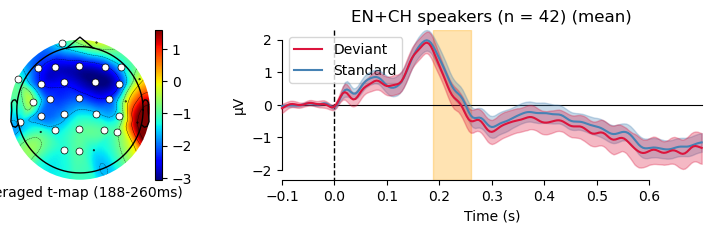

In [12]:
#######################
#### visualization ####
#######################

#### parameter ####
toggle_save_plot = False

# pick_chans = ['Cz']

# title
permutation_wave_title = subj_group + ' (n = ' + str(len(subset_subs)) + ')'

# What legend do you want to give to each type of stimuli? It shows in plots
legend_devi = 'Deviant'
legend_stan = 'Standard'




#### prepare data for waveform plotting ####
stan_data = [stan_dict[k] for k in stan_dict.keys()]
devi_data = [devi_dict[k] for k in devi_dict.keys()]

# organize data for plotting
evokeds = {
    legend_stan: stan_data,
    legend_devi: devi_data,
}


#### prepare data for topo plotting ####

# create a list of grand average differences
erp_diff_list = list(erp_diff.values())

grand_avg_diff = mne.grand_average(erp_diff_list)


## visualize clusters

if len(good_clusters_idx) > 0:
    
    # configure variables for visualization
    colors = {legend_devi: "crimson", legend_stan: "steelblue"}
    # linestyles = {"ChEn_d": "-", "ChEn_s": "--"}

    # loop over clusters
    for i_clu in range(len(good_clusters_idx)):
        # unpack cluster information, get unique indices
        time_inds, space_inds = np.squeeze(clusters[good_clusters_idx[i_clu]])

        # get channel indices
        ch_inds = np.unique(space_inds)
        # convert it to panda dataframe and save as .txt
        df = pd.DataFrame(ch_inds+1)
        df.to_csv('input/stats_channel_index_' + subj_group + '_All_blocks_cluster' + str(i_clu) + '.txt', header=False, index=False)
        # df.to_csv('input/stats_channel_index_' + subj_group + '_' + devi_key + '_minus_' + stan_key + '_cluster' + str(i_clu) + '.txt', header=False, index=False)
        
        # get time indices
        time_inds = np.unique(time_inds)
        # convert it to panda dataframe and save as .txt
        df = pd.DataFrame(time_inds+1)
        df.to_csv('input/stats_time_index_' + subj_group + '_All_blocks_cluster' + str(i_clu) + '.txt', header=False, index=False)
        # df.to_csv('input/stats_time_index_' + subj_group + '_' + devi_key + '_minus_' + stan_key + '_cluster' + str(i_clu) + '.txt', header=False, index=False)
        
        
        # get topography for F stat
        t_map = T_obs[time_inds, ...].mean(axis=0)

        # get signals at the sensors contributing to the cluster
        sig_times = epoch_info.times[time_inds]

        # create spatial mask
        mask = np.zeros((t_map.shape[0], 148), dtype=bool) # the number is obtained based on the error message, I don't know how to decide this number.
        mask[ch_inds, :] = True

        # initialize figure
        fig, ax_topo = plt.subplots(1, 1, figsize=(7, 5), layout="constrained")

        # plot topos of average test statistic and mark significant sensors
        t_evoked = mne.EvokedArray(t_map[:, np.newaxis]/1e6, epoch_info.info, tmin=0)
        t_evoked.plot_topomap(
            times=0,
            mask=mask,
            axes=ax_topo,
            cmap="jet",
            vlim=(np.min, np.max),
            show=False,
            colorbar=False,
            mask_params=dict(markersize=10),
        )
        image = ax_topo.images[0]

        # remove the title that would otherwise say "0.000 s"
        ax_topo.set_title("")

        # create additional axes (for ERF and colorbar)
        divider = make_axes_locatable(ax_topo)

        # add axes for colorbar
        ax_colorbar = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(image, cax=ax_colorbar)
        ax_topo.set_xlabel(
            "Averaged t-map ({:}-{:}ms)".format(int(sig_times[0]*1000), int(sig_times[-1]*1000))
        )

        # add new axis for time courses and plot time courses
        ax_signals = divider.append_axes("right", size="300%", pad=1.2)

        # plot waveforms
        plot_compare_evokeds(
            evokeds,
            title=permutation_wave_title,
            picks=ch_inds,
            axes=ax_signals,
            colors=colors,
            # linestyles=linestyles,
            show=False,
            split_legend=True,
            truncate_yaxis="auto",
            combine="mean",
        )
        

        # plot temporal cluster extent
        ymin, ymax = ax_signals.get_ylim()
        ax_signals.fill_betweenx(
            (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.3
        )

        # save
        if toggle_save_plot:
            fig.savefig(output_dir + 'permutation_' + subj_group + '_cluster' + str(i_clu) + '.png')



        # #### plotting topo of voltage ####
        # # figure axes
        # fig, ax = plt.subplots(1, 1, figsize=(3, 3))
        # ax_topo = fig.add_axes([0.9, 0.1, 0.05, 0.7])

        # t_evoked = mne.EvokedArray(t_map[:, np.newaxis], epoch_info.info, tmin=0)
        # t_evoked.plot_topomap(
        #     times=0,
        #     mask=mask,
        #     mask_params=dict(markersize=6 ),
        #     axes=[ax, ax_topo],
        #     # cmap="jet",
        #     vlim=(np.min, np.max),
        #     show=False,
        #     colorbar=True,
        # )
        
        # ax_topo.set_title("Your Title", fontsize=14)
        # ax.set_title('{:}-{:}ms'.format(int(sig_times[0]*1000), int(sig_times[-1]*1000)), fontsize=10)

    
        # save fig
        # if toggle_save_plot:
        #     fig.savefig(output_dir + 'permutation_voltage_topo_' + subj_group + '_' + 'cluster' + str(i_clu) + '.png', bbox_inches='tight')
    
    # plt.show()

## Visualization, waveform + t-map, for poster

Identifying common channels ...
combining channels using "mean"
combining channels using "mean"


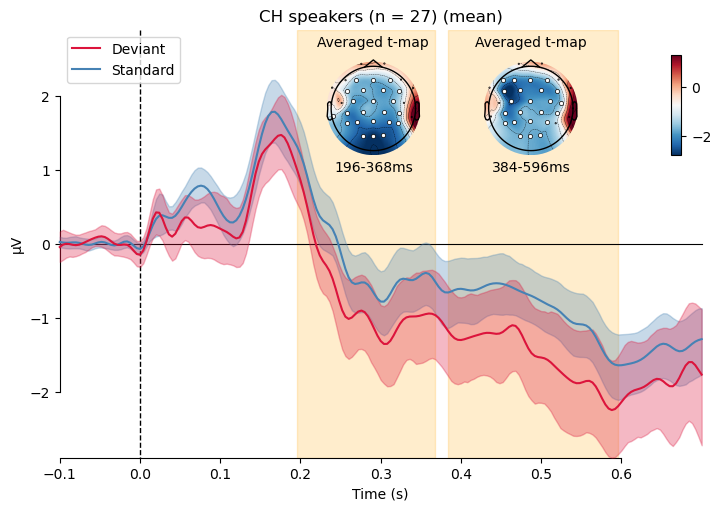

In [89]:
#######################
#### visualization, waveform + t-map, for poster ####
#######################

#### parameter ####
toggle_save_plot = True

# pick_chans = ['Cz']

# title
permutation_wave_title = subj_group + ' (n = ' + str(len(subset_subs)) + ')'

# What legend do you want to give to each type of stimuli? It shows in plots
legend_devi = 'Deviant'
legend_stan = 'Standard'




#### prepare data for waveform plotting ####
stan_data = [stan_dict[k] for k in stan_dict.keys()]
devi_data = [devi_dict[k] for k in devi_dict.keys()]

# organize data for plotting
evokeds = {
    legend_stan: stan_data,
    legend_devi: devi_data,
}


#### prepare data for topo plotting ####

# create a list of grand average differences
erp_diff_list = list(erp_diff.values())

grand_avg_diff = mne.grand_average(erp_diff_list)


## visualize clusters

if len(good_clusters_idx) > 0:
    
    # configure variables for visualization
    colors = {legend_devi: "crimson", legend_stan: "steelblue"}
    # linestyles = {"ChEn_d": "-", "ChEn_s": "--"}

    # loop over clusters
    for i_clu in range(len(good_clusters_idx)):
        # unpack cluster information, get unique indices
        time_inds, space_inds = np.squeeze(clusters[good_clusters_idx[i_clu]])

        # get channel indices
        ch_inds = np.unique(space_inds)
        # convert it to panda dataframe and save as .txt
        # df = pd.DataFrame(ch_inds+1)
        # df.to_csv('input/stats_channel_index_' + subj_group + '_All_blocks_cluster' + str(i_clu) + '.txt', header=False, index=False)
        # df.to_csv('input/stats_channel_index_' + subj_group + '_' + devi_key + '_minus_' + stan_key + '_cluster' + str(i_clu) + '.txt', header=False, index=False)
        
        # get time indices
        time_inds = np.unique(time_inds)
        # # convert it to panda dataframe and save as .txt
        # df = pd.DataFrame(time_inds+1)
        # # df.to_csv('input/stats_time_index_' + subj_group + '_All_blocks_cluster' + str(i_clu) + '.txt', header=False, index=False)
        # df.to_csv('input/stats_time_index_' + subj_group + '_' + devi_key + '_minus_' + stan_key + '_cluster' + str(i_clu) + '.txt', header=False, index=False)
        
        
        # get topography for F stat
        t_map = T_obs[time_inds, ...].mean(axis=0)/1e6

        # get signals at the sensors contributing to the cluster
        sig_times = epoch_info.times[time_inds]

        # create spatial mask
        mask = np.zeros((t_map.shape[0], 1), dtype=bool) # the number is obtained based on the error message, I don't know how to decide this number.
        mask[ch_inds, :] = True

        # initialize figure
        if i_clu==0:
            fig, ax_wave = plt.subplots(1, 1, figsize=(7, 5), layout="constrained")
            
            # plot waveforms
            plot_compare_evokeds(
                evokeds,
                title=permutation_wave_title,
                picks=ch_inds,
                axes=ax_wave,
                colors=colors,
                # linestyles=linestyles,
                show=False,
                split_legend=True,
                truncate_yaxis="auto",
                combine="mean",
            )
        

            # plot temporal cluster extent
            ymin, ymax = ax_wave.get_ylim()
            ax_wave.fill_betweenx(
                (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.2
            )

        # for the 2nd cluster of CH group
        else:
            ax_wave.fill_betweenx(
                (ymin, ymax), sig_times[0], sig_times[-1], color="orange", alpha=0.2
            )


        #### plotting topo of tmap ####

        # position for tmap topo
        if subj_group == 'CH speakers':
            if i_clu==0:
                ax_topo = fig.add_axes([0.425, 0.7, 0.2, 0.2]) # topo position for CH speaker cluster 1
                # Position for the colorbar
                cbar_ax = fig.add_axes([0.95, 0.7, 0.015, 0.2])
            else:
                ax_topo = fig.add_axes([0.65, 0.7, 0.2, 0.2])
        else:
            ax_topo = fig.add_axes([0.57, 0.7, 0.2, 0.2]) # topo position for EN speaker
            # Position for the colorbar
            cbar_ax = fig.add_axes([0.95, 0.7, 0.015, 0.2])



        # plot topos of average test statistic and mark significant sensors
        t_evoked = mne.EvokedArray(t_map[:, np.newaxis], epoch_info.info, tmin=0)
        t_evoked.plot_topomap(
            times=0,
            mask=mask,
            axes=ax_topo,
            # cmap="jet",
            vlim=(np.min, np.max),
            show=False,
            colorbar=False,
            mask_params=dict(markersize=6),
        )

        # ax_topo.set_title("Your Title", fontsize=14)
        ax_topo.set_title('Averaged t-map', fontsize=10)

        ax_topo.set_xlabel(
            "{:}-{:}ms".format(int(sig_times[0]*1000), int(sig_times[-1]*1000))
        )
        
        # add colorbar
        if i_clu == 0:
            image = ax_topo.images[0]
            plt.colorbar(image, cax=cbar_ax)
            cbar_ax.tick_params(labelsize=10)
            cbar_ax.yaxis.get_offset_text().set_fontsize(10)

    

        
        # save fig
        if toggle_save_plot:
            fig.savefig(output_dir + 'permutation_waveform+t-map_' + subj_group + '_' + devi_key + '_minus_' + stan_key + '.png', bbox_inches='tight')
    
    

# Time-frequency analysis

    Using multitaper spectrum estimation with 7 DPSS windows
Plotting power spectral density (dB=True).


/opt/anaconda3/lib/python3.11/site-packages/mne/viz/utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


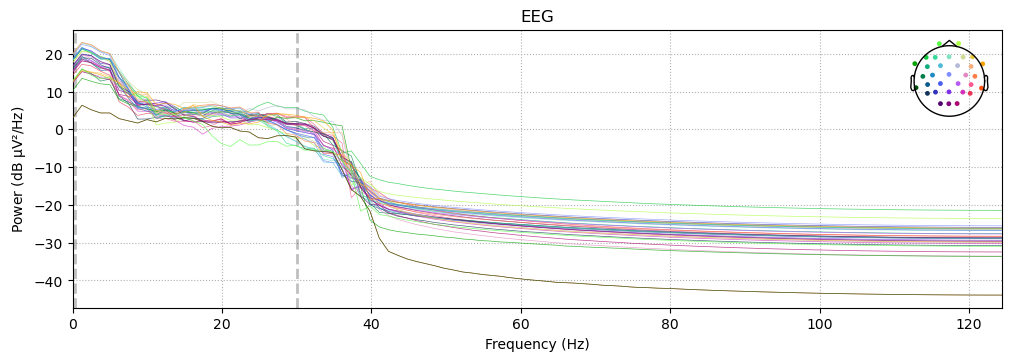

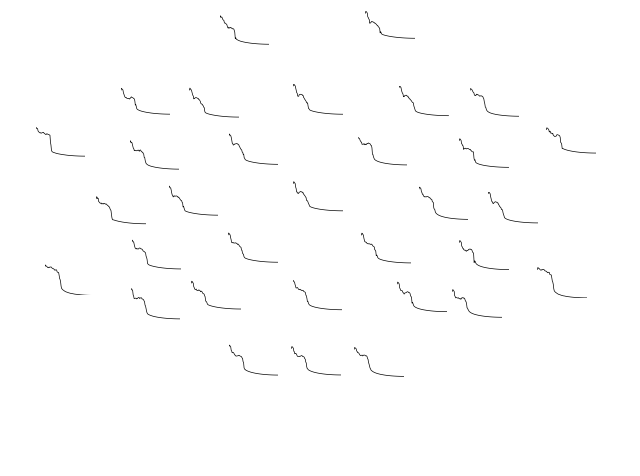

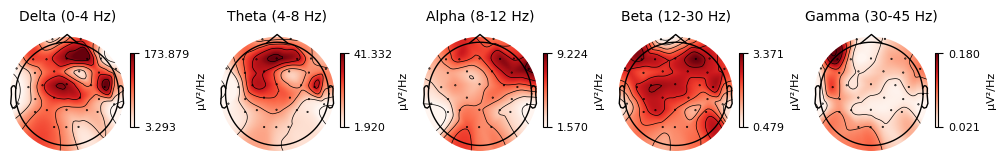

In [80]:
# test_data.compute_psd()
test_spectrum = test_data.compute_psd(
    method="multitaper",
    # tmin=0.3, tmax=0.5, 
    # fmin=5, fmax=30, 
    picks="eeg")

test_spectrum.plot(
    picks = "data",
    exclude = "bads",
    amplitude = False
)

test_spectrum.plot_topo(
    color = "k",
    fig_facecolor = "w",
    axis_facecolor = "w"
)


test_spectrum.plot_topomap(ch_type="eeg", agg_fun=np.median)

plt.show()

In [86]:
#### get ERP ####

# read in data
epochs = mne.read_epochs(input_dir + '../Yas_100_epoc.fif', preload = True)


Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/2_preprocessed/3_ica_all_thres0/4_filtered/5_epoched/6_erp/../Yas_100_epoc.fif ...
    Found the data of interest:
        t =    -100.00 ...     700.00 ms
        0 CTF compensation matrices available
Not setting metadata
2200 matching events found
No baseline correction applied
0 projection items activated


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_12419/2390430247.py:4: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/2_preprocessed/3_ica_all_thres0/4_filtered/5_epoched/6_erp/../Yas_100_epoc.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(input_dir + '../Yas_100_epoc.fif', preload = True)


In [7]:
# grand average

# directory
input_dir = work_dir + 'data_preprocessed/4_ersp/'
output_dir = work_dir + 'data_analysis/'
# create a folder if the folder doesn't exist
# os.makedirs(output_dir, exist_ok=True)

condition_list = ['ChEn-stan', 'ChEn-devi', 'EnCh-stan', 'EnCh-devi']

# get file names
all_input = os.listdir(input_dir)


# for each group
for ppt_group in ['ENG', 'CHI', 'SOME']:

    # for each condition
    for condition in condition_list:
        
        # initialize ERSP list
        tfrs = []

        for file in all_input:
    
            if file.endswith("tfr.hdf5") and (file.split('_')[1] in ppt_dict[ppt_group]):

                # exclude bad data
                if file.split('_')[1] in exclude_ppts:
                    continue
                
                # read in data
                power = mne.time_frequency.read_tfrs(fname=input_dir + file, condition=condition)

                # append
                tfrs.append(power)

        # create a list of grand average differences
        tfrs = mne.grand_average(tfrs)

        # save single subject file
        mne.time_frequency.write_tfrs(fname=output_dir + 'ersp_gav_' + ppt_group + '_' + condition + '.hdf5', 
                                      tfr=tfrs)

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_ersp/Yas_156_corr_prep_ica_tfr.hdf5 ...
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_ersp/Yas_123_corr_prep_ica_tfr.hdf5 ...
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_ersp/Yas_167_corr_prep_ica_tfr.hdf5 ...
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_ersp/Yas_124_corr_prep_ica_tfr.hdf5 ...
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_ersp/Yas_152_corr_prep_ica_tfr.hdf5 ...
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_preprocessed/4_ersp/Yas_163_corr_prep_ica_tfr.hdf5 ...
Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_CHI_ChEn-stan.hdf5 ...
Applying baseline correction (mode: logratio)


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_CHI_ChEn-stan.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


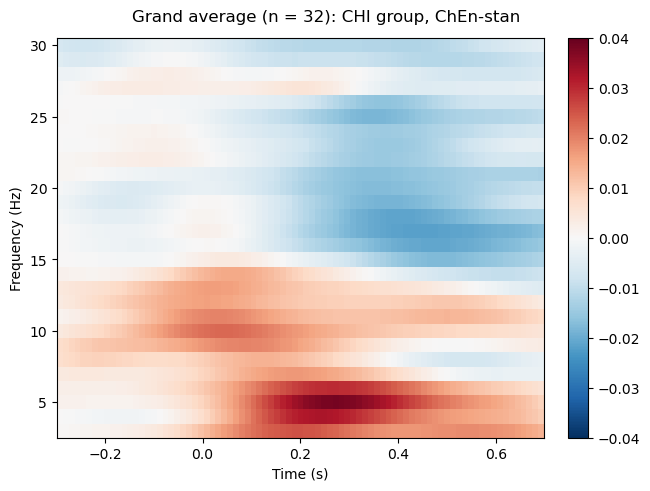

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_CHI_ChEn-devi.hdf5 ...
Applying baseline correction (mode: logratio)


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_CHI_ChEn-devi.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


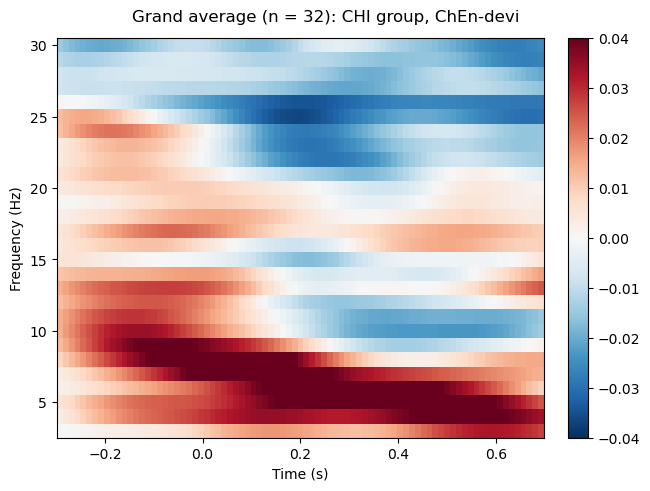

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_SOME_EnCh-stan.hdf5 ...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_SOME_EnCh-stan.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


Applying baseline correction (mode: logratio)


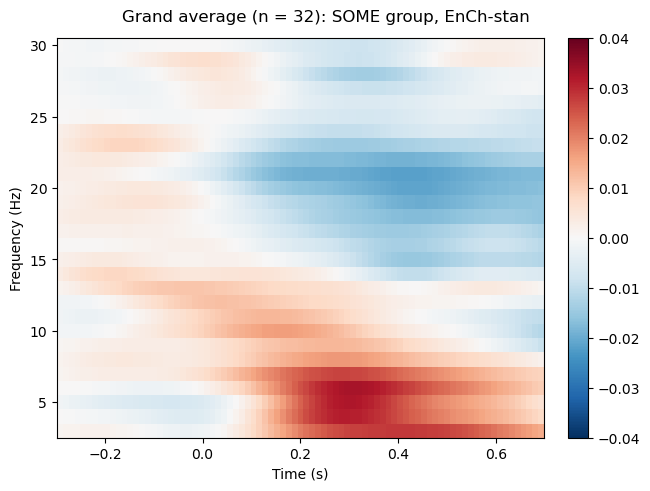

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_SOME_EnCh-devi.hdf5 ...
Applying baseline correction (mode: logratio)


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_SOME_EnCh-devi.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


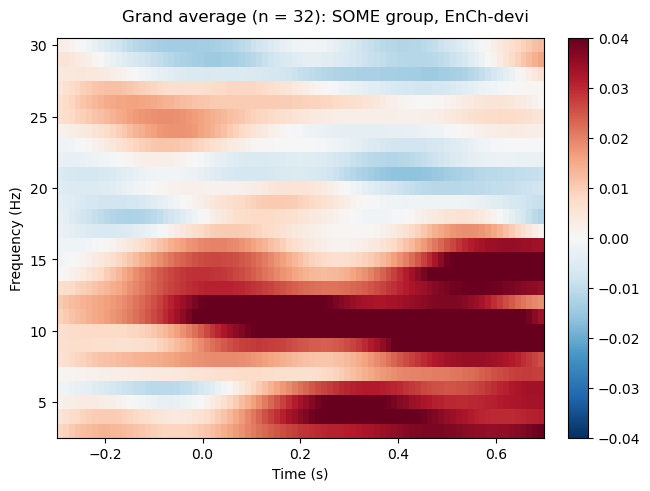

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_ENG_EnCh-devi.hdf5 ...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_ENG_EnCh-devi.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


Applying baseline correction (mode: logratio)


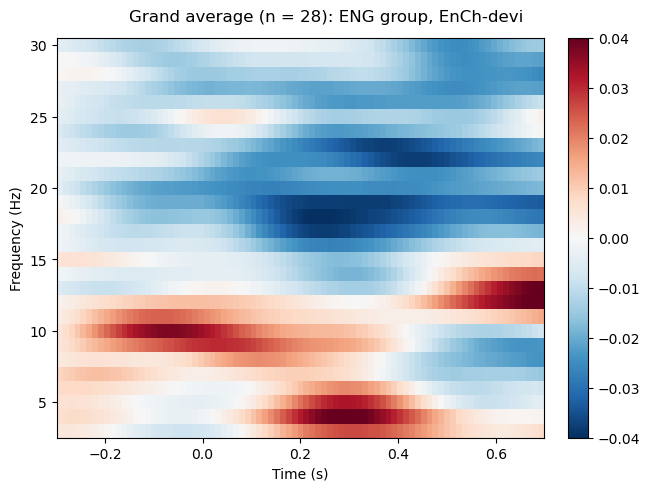

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_ENG_EnCh-stan.hdf5 ...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_ENG_EnCh-stan.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


Applying baseline correction (mode: logratio)


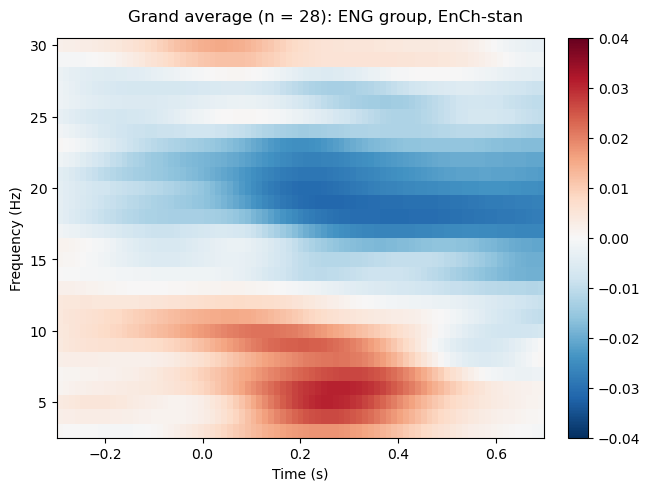

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_CHI_EnCh-stan.hdf5 ...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_CHI_EnCh-stan.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


Applying baseline correction (mode: logratio)


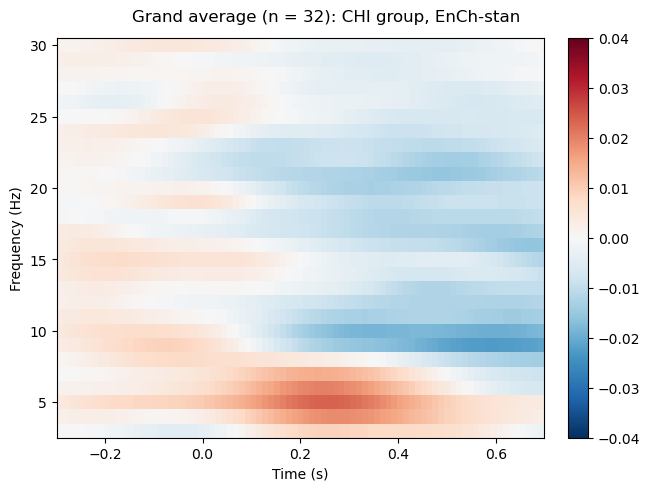

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_CHI_EnCh-devi.hdf5 ...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_CHI_EnCh-devi.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


Applying baseline correction (mode: logratio)


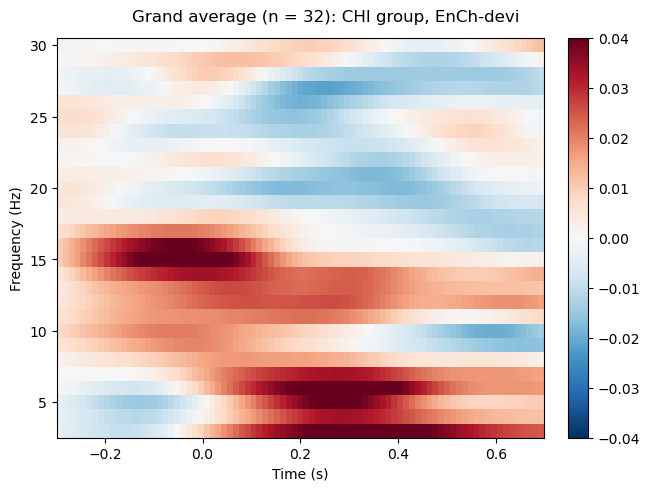

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_SOME_ChEn-stan.hdf5 ...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_SOME_ChEn-stan.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


Applying baseline correction (mode: logratio)


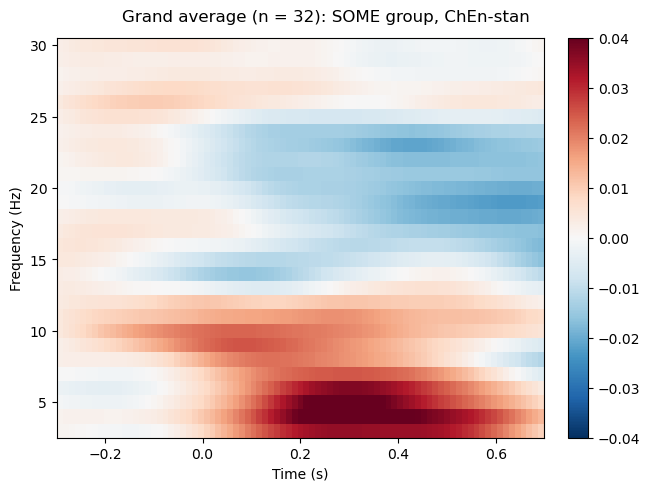

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_SOME_ChEn-devi.hdf5 ...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_SOME_ChEn-devi.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


Applying baseline correction (mode: logratio)


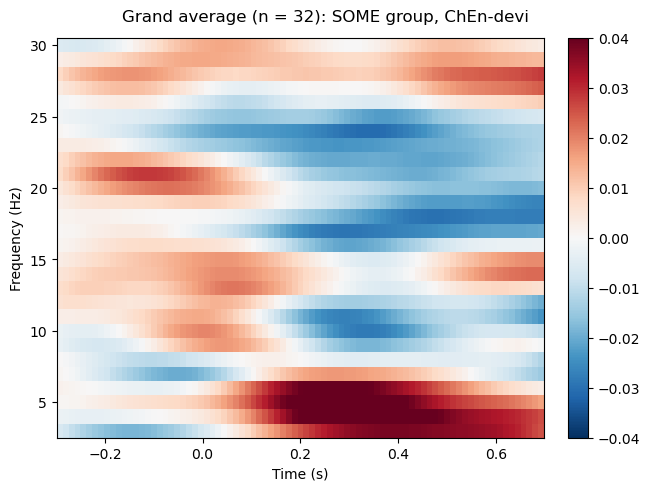

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_ENG_ChEn-devi.hdf5 ...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_ENG_ChEn-devi.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


Applying baseline correction (mode: logratio)


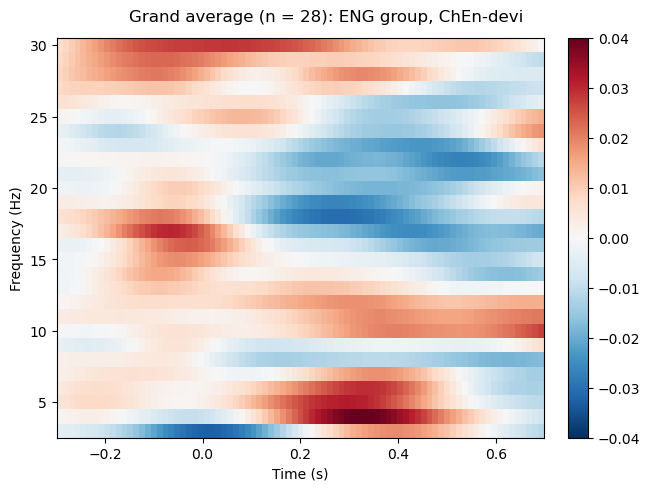

Reading /Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_ENG_ChEn-stan.hdf5 ...


/var/folders/j8/8nyf6njj5nzfjcv6s23y3nn40000gn/T/ipykernel_41375/2384090307.py:26: RuntimeWarning: This filename (/Users/chaohan/Library/CloudStorage/OneDrive-UniversityofToronto/Projects/Yas accent/data_analysis/ersp_gav_ENG_ChEn-stan.hdf5) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5, -tfr.hdf5, _tfr.h5 or _tfr.hdf5
  tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)


Applying baseline correction (mode: logratio)


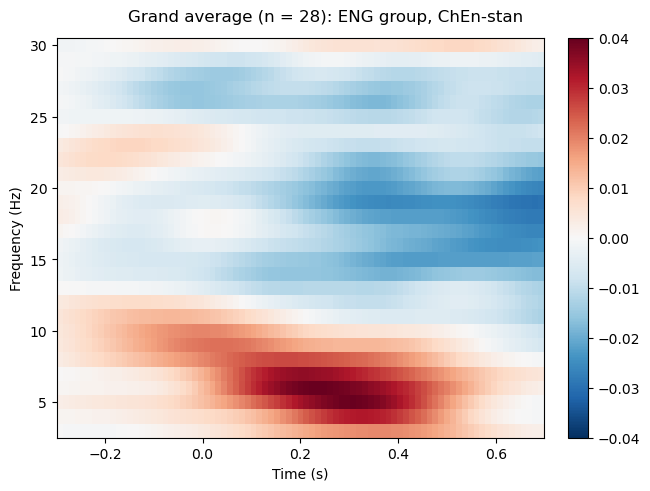

In [50]:
# do you want to save the plot?
toggle_save_plot = True
tfr_baseline = (-0.45, -0.3)

# directory
input_dir = work_dir + 'data_analysis/'
output_dir = work_dir + 'figures/'
# create a folder if the folder doesn't exist
# os.makedirs(output_dir, exist_ok=True)

condition_list = ['ChEn-stan', 'ChEn-devi', 'EnCh-stan', 'EnCh-devi']

# get file names
all_input = os.listdir(input_dir)


# for each group
for file in all_input:

    # for each condition
    if file.startswith('ersp_gav'):

        ppt_group = file.split('_')[2]
        condition = file.split('_')[3].split('.')[0]
        
        tfrs = mne.time_frequency.read_tfrs(fname = input_dir + file)

        # power
        fig = tfrs.plot(
            # picks='all', 
            baseline=tfr_baseline,
            mode='logratio',
            combine = 'mean',
            tmin=-0.3, tmax=0.7,
            title= tfrs.comment + ': ' + ppt_group + ' group, ' + condition,
            vlim = (-0.04, 0.04)
        )
        
        # save fig
        if toggle_save_plot:
            fig[0].savefig(output_dir + 'power_' + ppt_group + '_' + condition +'.png')

# release memory
del tfrs


# fig, axes = plt.subplots(1, 2, figsize=(7, 4), layout="constrained")
# topomap_kw = dict(
#     ch_type="eeg", tmin=0.5, tmax=1.5, baseline=(-0.5, 0), mode="logratio", show=False
# )
# plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))
# for ax, (title, fmin_fmax) in zip(axes, plot_dict.items()):
#     power.plot_topomap(**fmin_fmax, axes=ax, **topomap_kw)
#     ax.set_title(title)

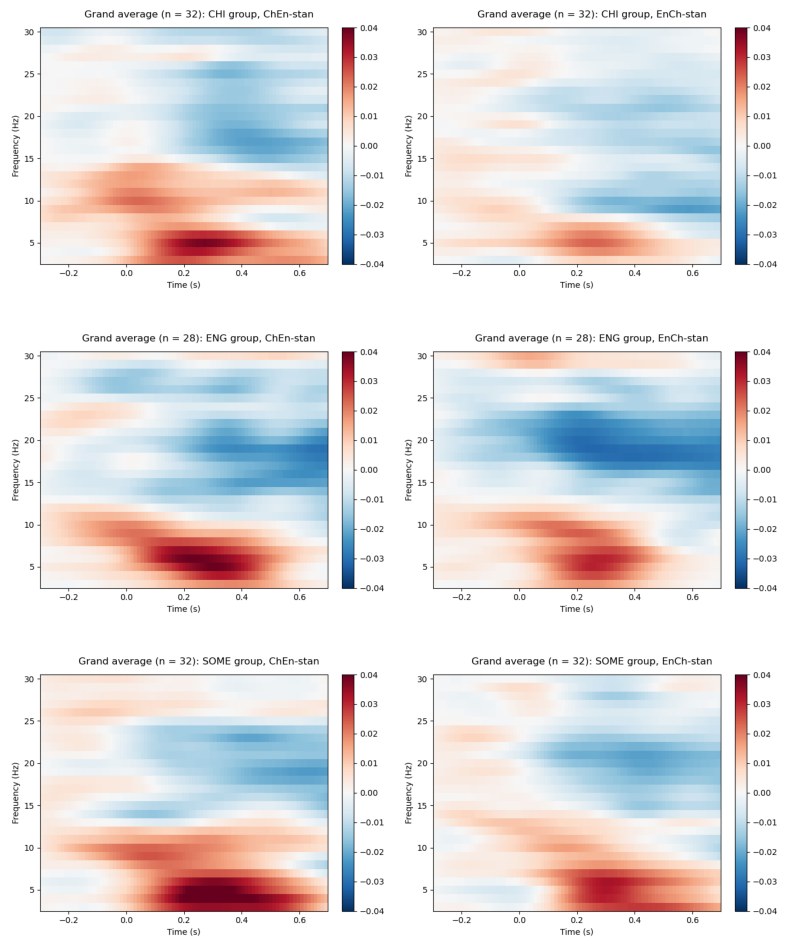

In [51]:
# combine figures
input_dir = work_dir + 'figures/'
output_dir = work_dir + 'figures/'

###############
image_files = [
    'power_CHI_ChEn-stan.png', 
    'power_CHI_EnCh-stan.png', 
    'power_ENG_ChEn-stan.png', 
    'power_ENG_EnCh-stan.png',
    'power_SOME_ChEn-stan.png',
    'power_SOME_EnCh-stan.png',
]

# Create a figure with 2 rows and 4 columns
fig, axes = plt.subplots(3, 2, figsize=(8, 10))

# Flatten axes array for easier iteration
axes = axes.flatten()

# Loop through images and add them as subplots
for ax, img_path in zip(axes, image_files):
    img = mpimg.imread(input_dir + img_path)  # Read image
    ax.imshow(img)  # Display image
    ax.axis("off")  # Hide axis

# Adjust layout
plt.tight_layout()

# Save the combined figure
plt.savefig(output_dir + 'power_combined.png', dpi=300, bbox_inches='tight')
############################